In [1]:
from weather_co2_dataset import WeatherCO2DataModule
import torch
import numpy as np
import pandas as pd


codes = ["BR-CS", "CA-ON", "CH", "DE", "PL", "BE", "IT-NO", "CA-QC", "ES", "GB", "FI", "FR", "NL"]

features_data = []
targets_data = []
for code in codes:
    features = np.load(f"electricitymaps_datasets/{code}_np_dataset.npy", allow_pickle=True)
    features_data.append(features)

    emission_df = pd.concat(
        (
            pd.read_csv(f"electricitymaps_datasets/{code}_2021_hourly.csv"),
            pd.read_csv(f"electricitymaps_datasets/{code}_2022_hourly.csv"),
        )
    ).reset_index(drop=True)
    target = emission_df["Carbon Intensity gCO₂eq/kWh (LCA)"].to_numpy()
    targets_data.append(target)


dm = WeatherCO2DataModule(
    features_data, targets_data, 24, 24, 10, 16
)
dm.setup('fit')

2023-07-18 10:58:04.298788: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-18 10:58:04.474802: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 10:58:05.197190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
len(dm.val_dataset.datasets[0])

5209

In [3]:
import sys
sys.path.append("scheduler_vm_task/master_machine/")


from scheduler_vm_task.master_machine.co2_model import CO2Model
from lightning.pytorch import Trainer
import os 

model = CO2Model(
    tcn_hparams={
        "num_inputs": 24*38,
        # "num_channels": [64, 128, 128, 128, 256],
        "num_channels": [512, 256, 256, 256, 256],
        "kernel_size": 3,
        "dropout": 0.0,
    },
    attention_layers_num = 8,
    predict_window=24,
    optimizer_name="Adam",
    optimizer_hparams={"lr": 1e-3, "weight_decay": 1e-4},
)

# For WandB local checkpoints
# def find_checkpoint(name):
#     folder = f'SmartScheduler/{name}/checkpoints'
#     for file in os.listdir(folder):
#         if file.endswith('.ckpt'):
#             return f'{folder}/{file}'

# # model = model.load_from_checkpoint(find_checkpoint('ya6oc29o'))
# model = model.load_from_checkpoint(find_checkpoint('fcqpzi1c'))
model = model.load_from_checkpoint('co2_model.ckpt')

# co2_model.ckpt can be downloaded here (rename it):
# https://api.wandb.ai/artifactsV2/gcp-us/mtyutyulnikov/QXJ0aWZhY3Q6NDc3MDUyNjUw/6c14bec74f1261169f7b083c1d27c6a9/model.ckpt?_gl=1*brpj4j*_ga*Mjk0MzUwODY2LjE2ODU2NzQ2NDY.*_ga_JH1SJHJQXJ*MTY4NjAzOTk3MC4xNi4xLjE2ODYwMzk5OTUuMzUuMC4w

# model = model.load_from_checkpoint('co2_model.ckpt')

trainer = Trainer(
    accelerator="gpu",
    devices=[0],
)

val_preds = trainer.predict(model, dm.val_dataloader())


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lazarev/disk/tiutiulnikov/miniconda3/envs/eco2ai/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/lazarev/disk/tiutiulnikov/miniconda3/envs/eco2ai/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this Data

Predicting: 0it [00:00, ?it/s]

In [4]:
len(val_preds), val_preds[0].shape, val_preds[-1].shape

(4233, torch.Size([16, 24]), torch.Size([5, 24]))

In [5]:
val_preds = torch.cat(val_preds, dim=0)
targets =  torch.stack([dm.val_dataset[idx][1] for idx in range(len(dm.val_dataset))])
val_preds.shape, targets.shape

(torch.Size([67717, 24]), torch.Size([67717, 24]))

In [6]:
features = torch.stack([dm.val_dataset[i][0] for i in range(len(dm.val_dataset))])
features.shape

torch.Size([67717, 24, 24, 38])

In [7]:
# torch.save(features, 'features.pt')
# torch.save(val_preds, 'preds.pt')
# torch.save(targets, 'targets.pt')


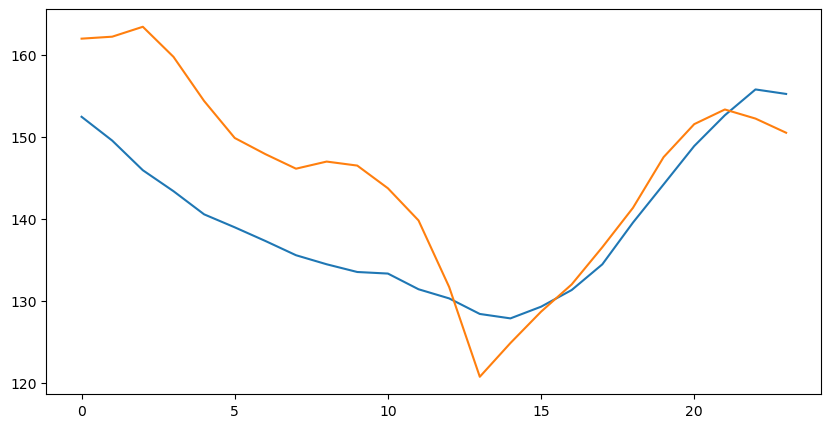

In [8]:
import matplotlib.pyplot as plt

sample_id = 200
plt.figure(figsize=(10, 5))
plt.plot(val_preds[sample_id], label='pred')
plt.plot(targets[sample_id] , label='val')

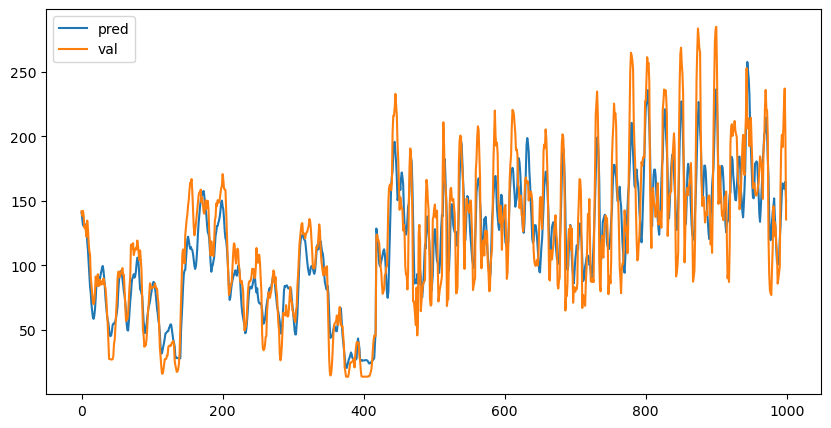

In [9]:
import matplotlib.pyplot as plt

time_step = 0
s1, s2 = 10000, 11000
plt.figure(figsize=(10, 5))
plt.plot(val_preds[s1 :s2, time_step], label='pred')
plt.plot(targets[s1 :s2, time_step] , label='val')
plt.legend()

In [10]:
from sklearn.metrics import mean_absolute_error
for i in range(24):
    print(f'Forecast time_step {i}: \t MAE = {mean_absolute_error(val_preds[:, i], targets[:, i])}')

Forecast time_step 0: 	 MAE = 12.462915420532227
Forecast time_step 1: 	 MAE = 14.813271522521973
Forecast time_step 2: 	 MAE = 17.096477508544922
Forecast time_step 3: 	 MAE = 19.063737869262695
Forecast time_step 4: 	 MAE = 20.743940353393555
Forecast time_step 5: 	 MAE = 22.149444580078125
Forecast time_step 6: 	 MAE = 23.388858795166016
Forecast time_step 7: 	 MAE = 24.49115562438965
Forecast time_step 8: 	 MAE = 25.479801177978516
Forecast time_step 9: 	 MAE = 26.373878479003906
Forecast time_step 10: 	 MAE = 27.196096420288086
Forecast time_step 11: 	 MAE = 27.90863800048828
Forecast time_step 12: 	 MAE = 28.558507919311523
Forecast time_step 13: 	 MAE = 29.17340660095215
Forecast time_step 14: 	 MAE = 29.695903778076172
Forecast time_step 15: 	 MAE = 30.147560119628906
Forecast time_step 16: 	 MAE = 30.54631233215332
Forecast time_step 17: 	 MAE = 30.85930061340332
Forecast time_step 18: 	 MAE = 31.04911994934082
Forecast time_step 19: 	 MAE = 31.108333587646484
Forecast time_st

In [11]:
print(f'Total MAE = {mean_absolute_error(val_preds, targets)}')

Total MAE = 26.11539649963379


In [12]:
# Dataset idx from 0 to 12

from sklearn.metrics import mean_absolute_percentage_error
def calc_mape_with_period(predict_period = 24, plot = True, dataset_idx = 0):
    preds = []
    real = []
    codes = ["BR-CS", "CA-ON", "CH", "DE", "PL", "BE", "IT-NO", "CA-QC", "ES", "GB", "FI", "FR", "NL"]


    start_idx = dataset_idx * len(dm.val_dataset.datasets[0])
    end_idx = start_idx + len(dm.val_dataset.datasets[0])
    for i in range(start_idx, end_idx, predict_period):
        preds.extend(val_preds[i, :predict_period])
        real.extend(targets[i, :predict_period])
        # plt.axvline(i, color='r', ds='steps-pre')
    
    if plot:
        plt.figure(figsize=(20, 5))
        plt.plot(preds, label = f'forecast_{predict_period}h_step')
        plt.plot(real, label='real_val')
        plt.legend()
    # print(preds[0])

    

    # print(codes[dataset_idx], mean_absolute_percentage_error(preds, real).round(4)*100)
    return codes[dataset_idx], mean_absolute_percentage_error(preds, real)*100

In [13]:
predict_period_mapes = []

for p in range(1, 25):
    mapes = {}
    for i in range(13):
        code, mape = calc_mape_with_period(predict_period=p, plot=False, dataset_idx=i)
        # print(code, mape)
        mapes[code] = mape
    predict_period_mapes.append(mapes)

In [14]:
len(predict_period_mapes)

24

Text(0.5, 0, 'Prediction period, h')

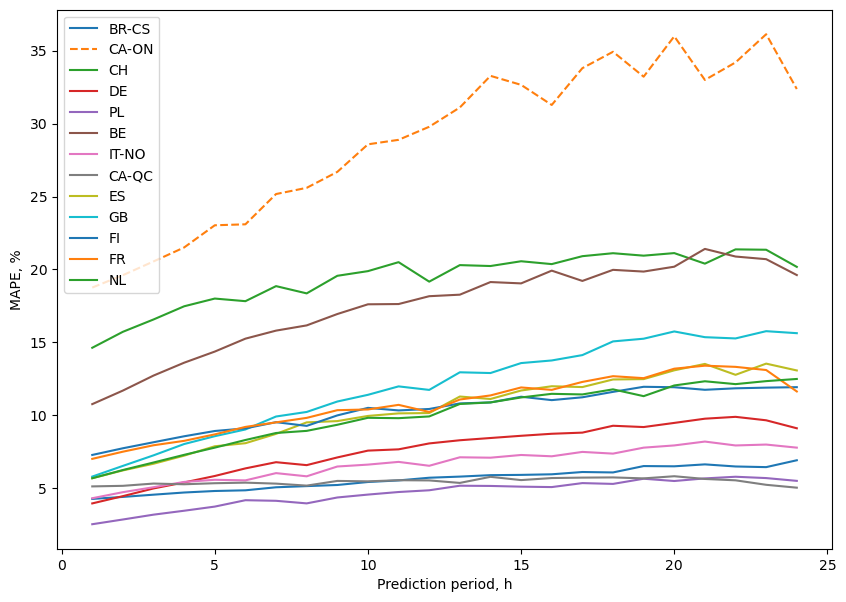

In [15]:
plt.figure(figsize=(10, 7))
for code in predict_period_mapes[0].keys():
    mapes = [d[code] for d in predict_period_mapes]
    if code == 'CA-ON':
        plt.plot(range(1, 25), mapes, label = code, linestyle='dashed')
    else:
        plt.plot(range(1, 25), mapes, label = code, )
    plt.legend()

plt.ylabel('MAPE, %')
plt.xlabel('Prediction period, h')

In [16]:
# Dataset idx from 0 to 12

from sklearn.metrics import mean_absolute_percentage_error
def calc_mape_for_country(forecast_time_step = 1, dataset_idx = 0):
    preds = []
    real = []
    codes = ["BR-CS", "CA-ON", "CH", "DE", "PL", "BE", "IT-NO", "CA-QC", "ES", "GB", "FI", "FR", "NL"]


    start_idx = dataset_idx * len(dm.val_dataset.datasets[0])
    end_idx = start_idx + len(dm.val_dataset.datasets[0])

    preds = val_preds[start_idx : end_idx]
    real = targets[start_idx : end_idx]
    
    return codes[dataset_idx], mean_absolute_percentage_error(preds[:, forecast_time_step-1], real[:, forecast_time_step-1])*100

In [17]:
countries_mapes = {}
for code_idx in range(13):
    country_mapes = []
    for time_step in range(1, 25):
        code, mape = calc_mape_for_country(time_step, code_idx)
        country_mapes.append(mape)
    countries_mapes[code] = country_mapes


Text(0, 0.5, 'MAPE, %')

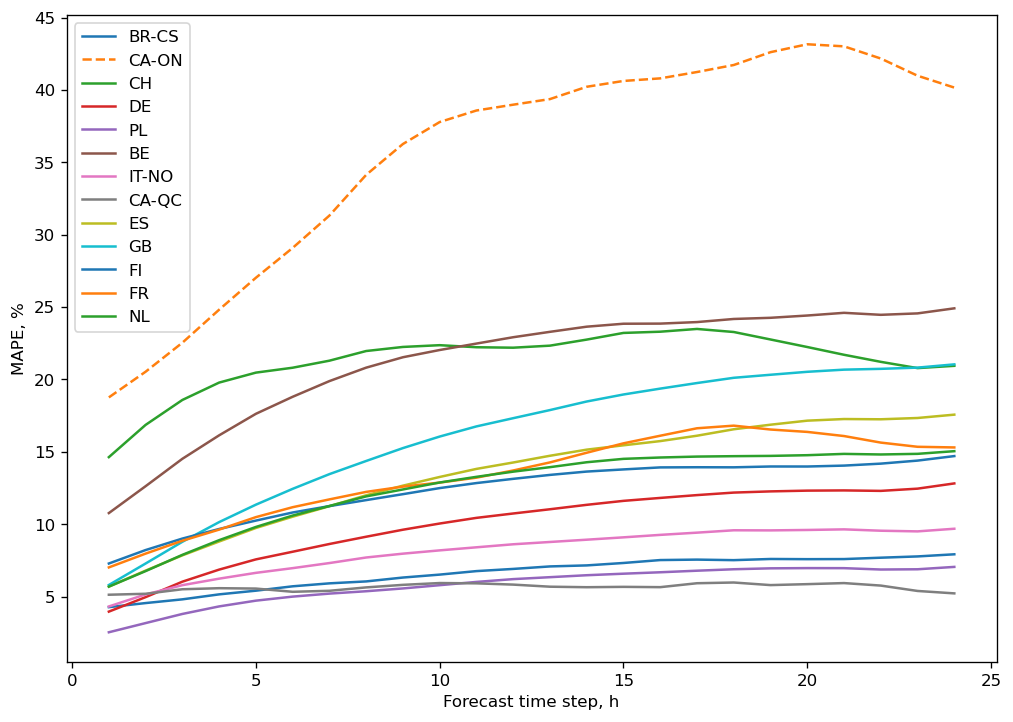

In [23]:
plt.figure(figsize=(10, 7), dpi=120)
for code in countries_mapes.keys():
    if code == 'CA-ON':
        plt.plot(range(1, 25), countries_mapes[code], label=code, linestyle='dashed')
    else:
        plt.plot(range(1, 25), countries_mapes[code], label=code,)
plt.legend()
plt.xlabel('Forecast time step, h')
plt.ylabel('MAPE, %')

In [19]:
import pandas as pd
codes = ["BR-CS", "CA-ON", "CH", "DE", "PL", "BE", "IT-NO", "CA-QC", "ES", "GB", "FI", "FR", "NL"]

e = []
for code in codes:
    emission_df = pd.concat(
        (
            pd.read_csv(f"electricitymaps_datasets/{code}_2021_hourly.csv"),
            pd.read_csv(f"electricitymaps_datasets/{code}_2022_hourly.csv"),
        )
    ).reset_index(drop=True)

    emission = emission_df['Carbon Intensity gCO₂eq/kWh (LCA)']
    e.append(emission.to_numpy())


Text(0.5, 1.0, 'CO2 emission intensity in electricitymaps zones')

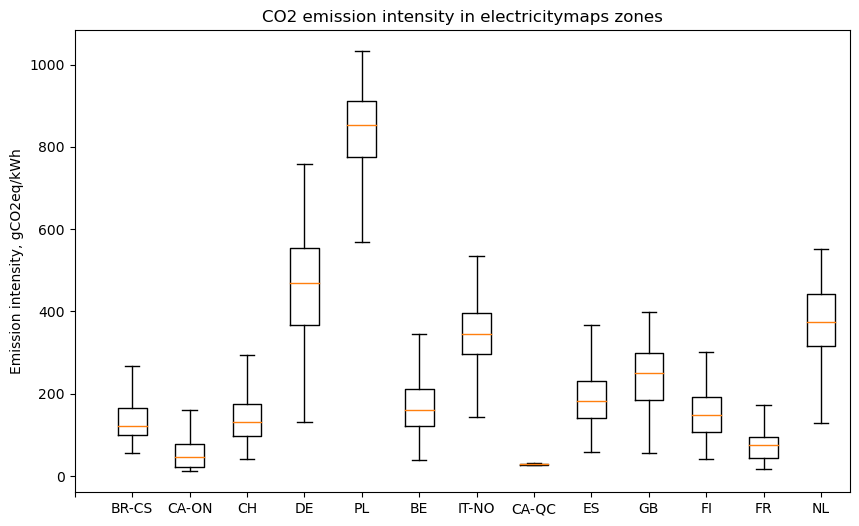

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.boxplot(e, showfliers=False)

ax.set_xticks(list(range(14)))
ax.set_xticklabels([''] + codes)
ax.set_ylabel('Emission intensity, gCO2eq/kWh')

plt.title('CO2 emission intensity in electricitymaps zones')